# RE-ANALYSE PUBLICLY AVAILABLE DATA BY ALDINGER ET AL IN ORDER TO CREATE PSEUDOBULK CELL TYPE EXPRESSION

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
from matplotlib import rcParams
import matplotlib
from SCCAF import SCCAF_assessment, plot_roc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white',  dpi_save=600)

In [3]:
results_file = '/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/AldingerEtal2020_adata.h5ad'  # the file that will store the analysis results

## READ IN THE DATA AND CHECK AT QC METRICES

In [4]:
adata = sc.read_loom("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/AldingerEtal2020/AldingerEtal_seurat_obj.loom")

In [ ]:
meta = pd.read_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/AldingerEtal2020/meta.tsv", sep="\t")
adata.obs = meta

In [9]:
adata.obs = meta

In [10]:
adata.obs

cellId           Cluster orig.ident  nCount_RNA  nFeature_RNA  \
0           V3_1           10-Glia        01k         617           482   
1         V224_1           10-Glia        01k        1733          1147   
2         V364_1           10-Glia        01k        1475           974   
3         V372_1           10-Glia        01k         966           718   
4         V434_1           10-Glia        01k        1266           977   
...          ...               ...        ...         ...           ...   
69169  s9.7960_4  12-Committed OPC        80k        7230          3205   
69170  s9.7976_4  12-Committed OPC        80k        4347          2313   
69171  s9.8008_4  12-Committed OPC        80k        1298           803   
69172  s9.7293_4  12-Committed OPC        80k        6995          3242   
69173  s9.4694_4  12-Committed OPC        80k        3071          1845   

      sample_id  percent.mito   S.Score  G2M.Score Phase  CC.Difference  \
0         13379      0.012966 -0.012428  -0.012529    G1       0.000101   
1         13379      0.010964 -0.034455  -0.018944    G1      -0.015511   
2         13379      0.027797 -0.026429  -0.001327    G1      -0.025102   
3         13379      0.010352  0.060085  -0.000183     S       0.060267   
4         13379      0.030806 -0.029667   0.204746   G2M      -0.234413   
...         ...           ...       ...        ...   ...            ...   
69169     13928           NaN -0.003025  -0.011117    G1       0.008092   
69170     13928           NaN  0.001187  -0.023190     S       0.024377   
69171     13928           NaN -0.006057  -0.023486    G1       0.017428   
69172     13928           NaN -0.023958  -0.003281    G1      -0.020677   
69173     13928           NaN -0.017198   0.010903   G2M      -0.028101   

       nCount_SCT  nFeature_SCT     age   figure_clusters sex    type  \
0             783           480  12 PCW           10-Glia   F   cells   
1            1483          1135  12 PCW           10-Glia   F   cells   
2            1350           962  12 PCW           10-Glia   F   cells   
3             966           709  12 PCW           10-Glia   F   cells   
4            1247           966  12 PCW           10-Glia   F   cells   
...           ...           ...     ...               ...  ..     ...   
69169        1868          1162  20 PCW  12-Committed OPC   M  nuclei   
69170        2698          2025  20 PCW  12-Committed OPC   M  nuclei   
69171        1530           803  20 PCW  12-Committed OPC   M  nuclei   
69172        1860          1256  20 PCW  12-Committed OPC   M  nuclei   
69173        2496          1825  20 PCW  12-Committed OPC   M  nuclei   

       experiment  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
69169           3  
69170           3  
69171           3  
69172           3  
69173           3  

[69174 rows x 18 columns]

normalizing counts per cell
    finished (0:00:02)


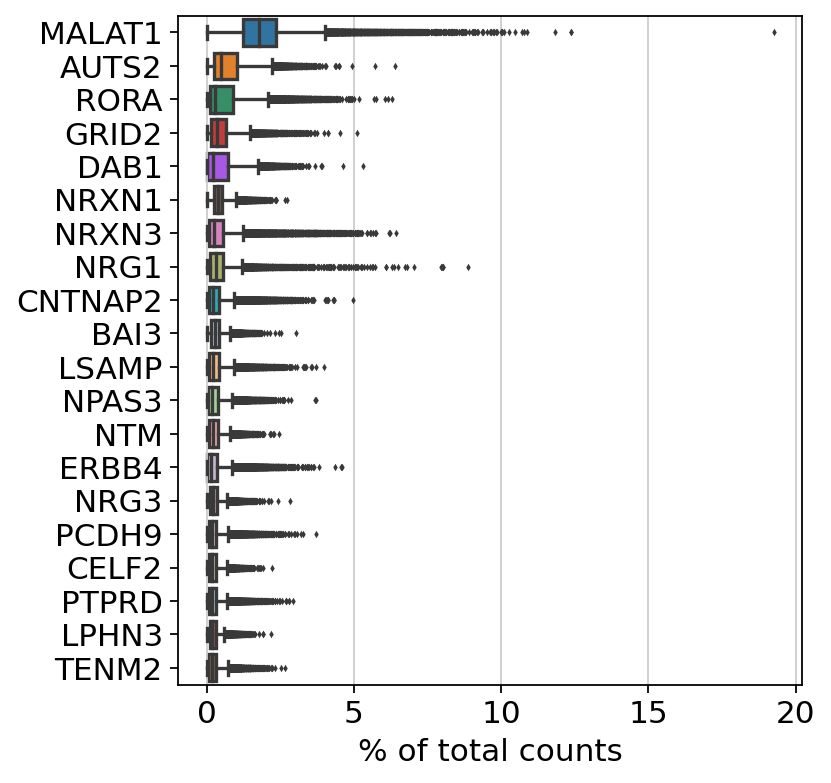

In [11]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


filtered out 7699 genes that are detected in less than 3 cells


In [13]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

In [14]:
adata.obs

cellId           Cluster orig.ident  nCount_RNA  nFeature_RNA  \
0           V3_1           10-Glia        01k         617           482   
1         V224_1           10-Glia        01k        1733          1147   
2         V364_1           10-Glia        01k        1475           974   
3         V372_1           10-Glia        01k         966           718   
4         V434_1           10-Glia        01k        1266           977   
...          ...               ...        ...         ...           ...   
69169  s9.7960_4  12-Committed OPC        80k        7230          3205   
69170  s9.7976_4  12-Committed OPC        80k        4347          2313   
69171  s9.8008_4  12-Committed OPC        80k        1298           803   
69172  s9.7293_4  12-Committed OPC        80k        6995          3242   
69173  s9.4694_4  12-Committed OPC        80k        3071          1845   

      sample_id  percent.mito   S.Score  G2M.Score Phase  ...  sex    type  \
0         13379      0.012966 -0.012428  -0.012529    G1  ...    F   cells   
1         13379      0.010964 -0.034455  -0.018944    G1  ...    F   cells   
2         13379      0.027797 -0.026429  -0.001327    G1  ...    F   cells   
3         13379      0.010352  0.060085  -0.000183     S  ...    F   cells   
4         13379      0.030806 -0.029667   0.204746   G2M  ...    F   cells   
...         ...           ...       ...        ...   ...  ...  ...     ...   
69169     13928           NaN -0.003025  -0.011117    G1  ...    M  nuclei   
69170     13928           NaN  0.001187  -0.023190     S  ...    M  nuclei   
69171     13928           NaN -0.006057  -0.023486    G1  ...    M  nuclei   
69172     13928           NaN -0.023958  -0.003281    G1  ...    M  nuclei   
69173     13928           NaN -0.017198   0.010903   G2M  ...    M  nuclei   

       experiment n_genes n_genes_by_counts total_counts total_counts_mt  \
0               1     482               482  1445.729248        8.311615   
1               1    1147              1147  2452.322754        9.737492   
2               1     974               974  2208.161133       11.713949   
3               1     718               717  1864.679443        7.506114   
4               1     977               977  2281.649414       19.216965   
...           ...     ...               ...          ...             ...   
69169           3    3205              3205  7230.000000       39.000000   
69170           3    2313              2312  4346.000000       15.000000   
69171           3     803               803  1298.000000        3.000000   
69172           3    3242              3242  6995.000000       46.000000   
69173           3    1845              1845  3071.000000       10.000000   

       pct_counts_mt  total_counts_ribo  pct_counts_ribo  
0           0.574908          11.381371         0.787241  
1           0.397072          11.475309         0.467936  
2           0.530484          17.038820         0.771629  
3           0.402542           7.288173         0.390854  
4           0.842240          16.572128         0.726322  
...              ...                ...              ...  
69169       0.539419          50.000000         0.691563  
69170       0.345145          13.000000         0.299126  
69171       0.231125           1.000000         0.077042  
69172       0.657613          23.000000         0.328806  
69173       0.325627          18.000000         0.586128  

[69174 rows x 25 columns]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Cluster' as categorical
... storing 'orig.ident' as categorical
... storing 'sample_id' as categorical
... storing 'Phase' as categorical
... storing 'age' as categorical
... storing 'figure_clusters' as categorical
... storing 'sex' as categorical
... storing 'type' as categorical


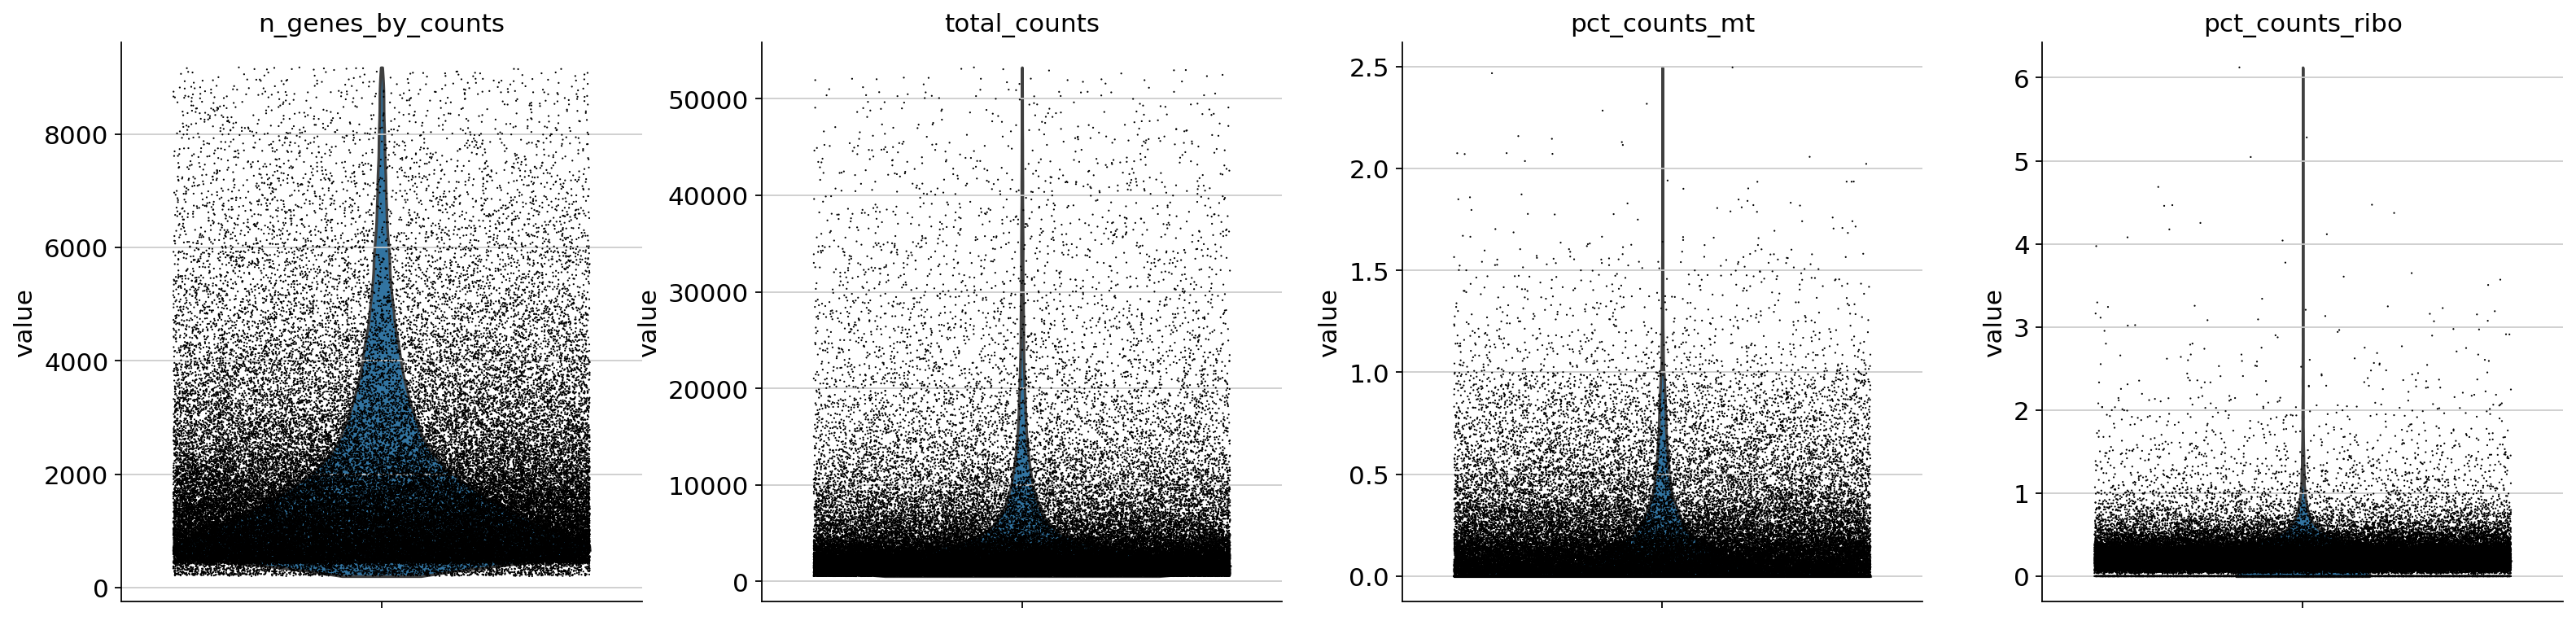

In [15]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

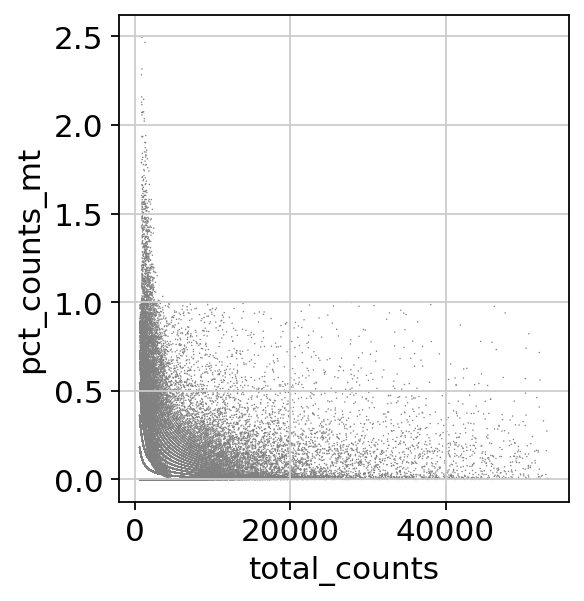

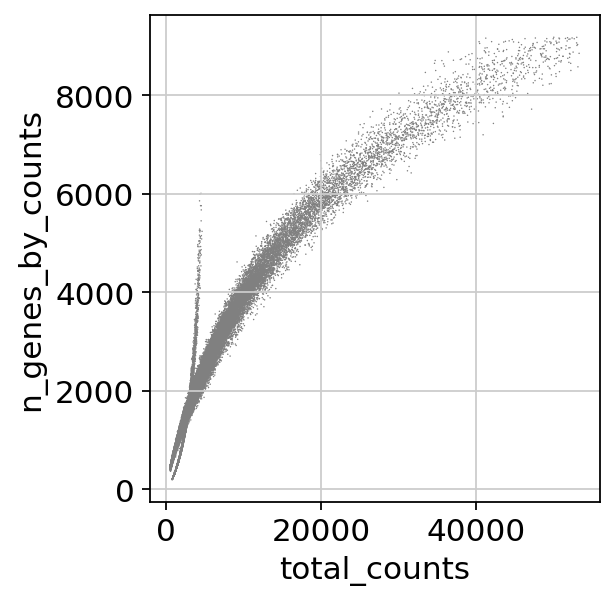

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

1821.801529476393
4325.626953125


In [19]:
adata.obs

cellId           Cluster orig.ident  nCount_RNA  nFeature_RNA  \
0           V3_1           10-Glia        01k         617           482   
1         V224_1           10-Glia        01k        1733          1147   
2         V364_1           10-Glia        01k        1475           974   
3         V372_1           10-Glia        01k         966           718   
4         V434_1           10-Glia        01k        1266           977   
...          ...               ...        ...         ...           ...   
69169  s9.7960_4  12-Committed OPC        80k        7230          3205   
69170  s9.7976_4  12-Committed OPC        80k        4347          2313   
69171  s9.8008_4  12-Committed OPC        80k        1298           803   
69172  s9.7293_4  12-Committed OPC        80k        6995          3242   
69173  s9.4694_4  12-Committed OPC        80k        3071          1845   

      sample_id  percent.mito   S.Score  G2M.Score Phase  ...  sex    type  \
0         13379      0.012966 -0.012428  -0.012529    G1  ...    F   cells   
1         13379      0.010964 -0.034455  -0.018944    G1  ...    F   cells   
2         13379      0.027797 -0.026429  -0.001327    G1  ...    F   cells   
3         13379      0.010352  0.060085  -0.000183     S  ...    F   cells   
4         13379      0.030806 -0.029667   0.204746   G2M  ...    F   cells   
...         ...           ...       ...        ...   ...  ...  ...     ...   
69169     13928           NaN -0.003025  -0.011117    G1  ...    M  nuclei   
69170     13928           NaN  0.001187  -0.023190     S  ...    M  nuclei   
69171     13928           NaN -0.006057  -0.023486    G1  ...    M  nuclei   
69172     13928           NaN -0.023958  -0.003281    G1  ...    M  nuclei   
69173     13928           NaN -0.017198   0.010903   G2M  ...    M  nuclei   

       experiment n_genes n_genes_by_counts total_counts total_counts_mt  \
0               1     482               482  1445.729248        8.311615   
1               1    1147              1147  2452.322754        9.737492   
2               1     974               974  2208.161133       11.713949   
3               1     718               717  1864.679443        7.506114   
4               1     977               977  2281.649414       19.216965   
...           ...     ...               ...          ...             ...   
69169           3    3205              3205  7230.000000       39.000000   
69170           3    2313              2312  4346.000000       15.000000   
69171           3     803               803  1298.000000        3.000000   
69172           3    3242              3242  6995.000000       46.000000   
69173           3    1845              1845  3071.000000       10.000000   

       pct_counts_mt  total_counts_ribo  pct_counts_ribo  
0           0.574908          11.381371         0.787241  
1           0.397072          11.475309         0.467936  
2           0.530484          17.038820         0.771629  
3           0.402542           7.288173         0.390854  
4           0.842240          16.572128         0.726322  
...              ...                ...              ...  
69169       0.539419          50.000000         0.691563  
69170       0.345145          13.000000         0.299126  
69171       0.231125           1.000000         0.077042  
69172       0.657613          23.000000         0.328806  
69173       0.325627          18.000000         0.586128  

[69174 rows x 25 columns]

## PERFORM NORMALIZATION AND PCA

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


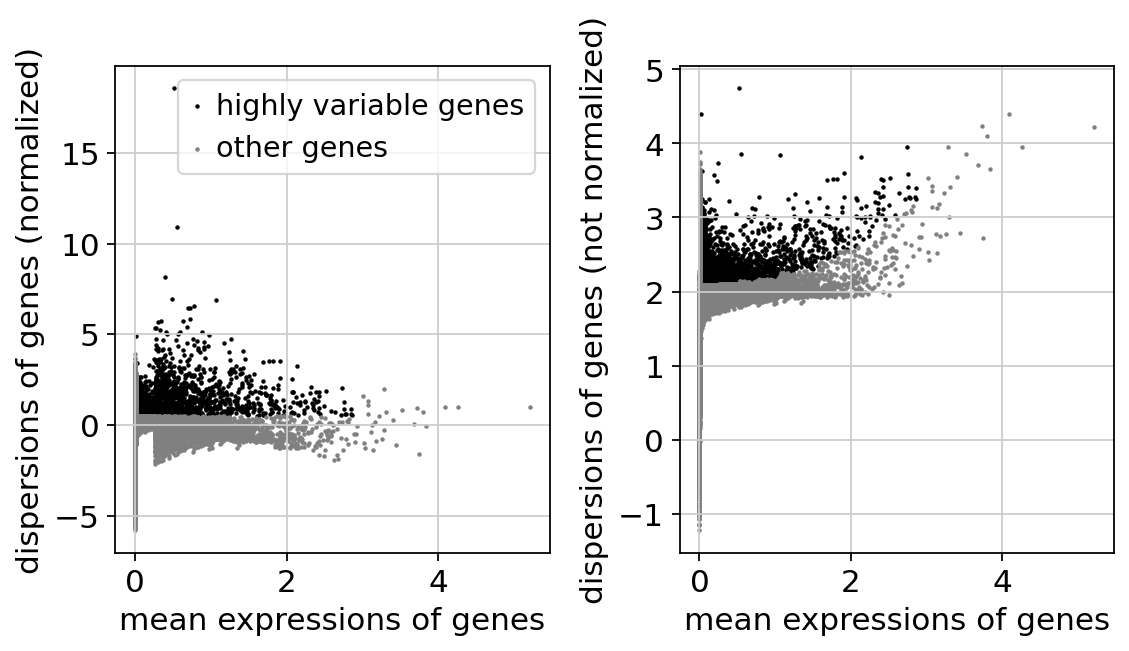

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
# set the raw attribute of anndata
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [26]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished (0:10:01)


In [27]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:22)


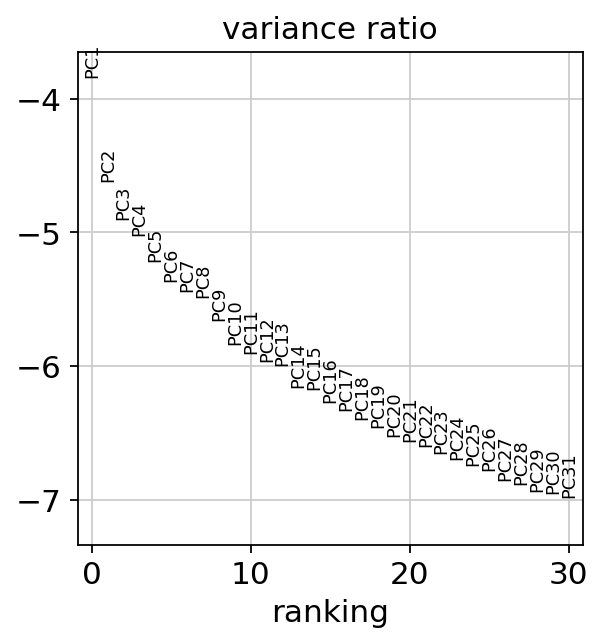

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [33]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata,
            n_components=2,
            min_dist=0.1,  # Scanpy default = 0.05
            spread=1.0,  # Scanpy default = 1.0

            # For some reason cannot access neighbors key slot, thus we
            # must keep uns['neighbors'] until we have run this.
            # neighbors_key='neighbors__{}'.format(plt__label),
               copy=False,
            random_state=0
        )
sc.tl.leiden(adata, resolution= 1.0)

computing neighbors
    using 'X_pca' with n_pcs = 30


/home/przybilm/.local/lib/python3.7/site-packages/numba/core/typed_passes.py:332: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:37)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:50)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


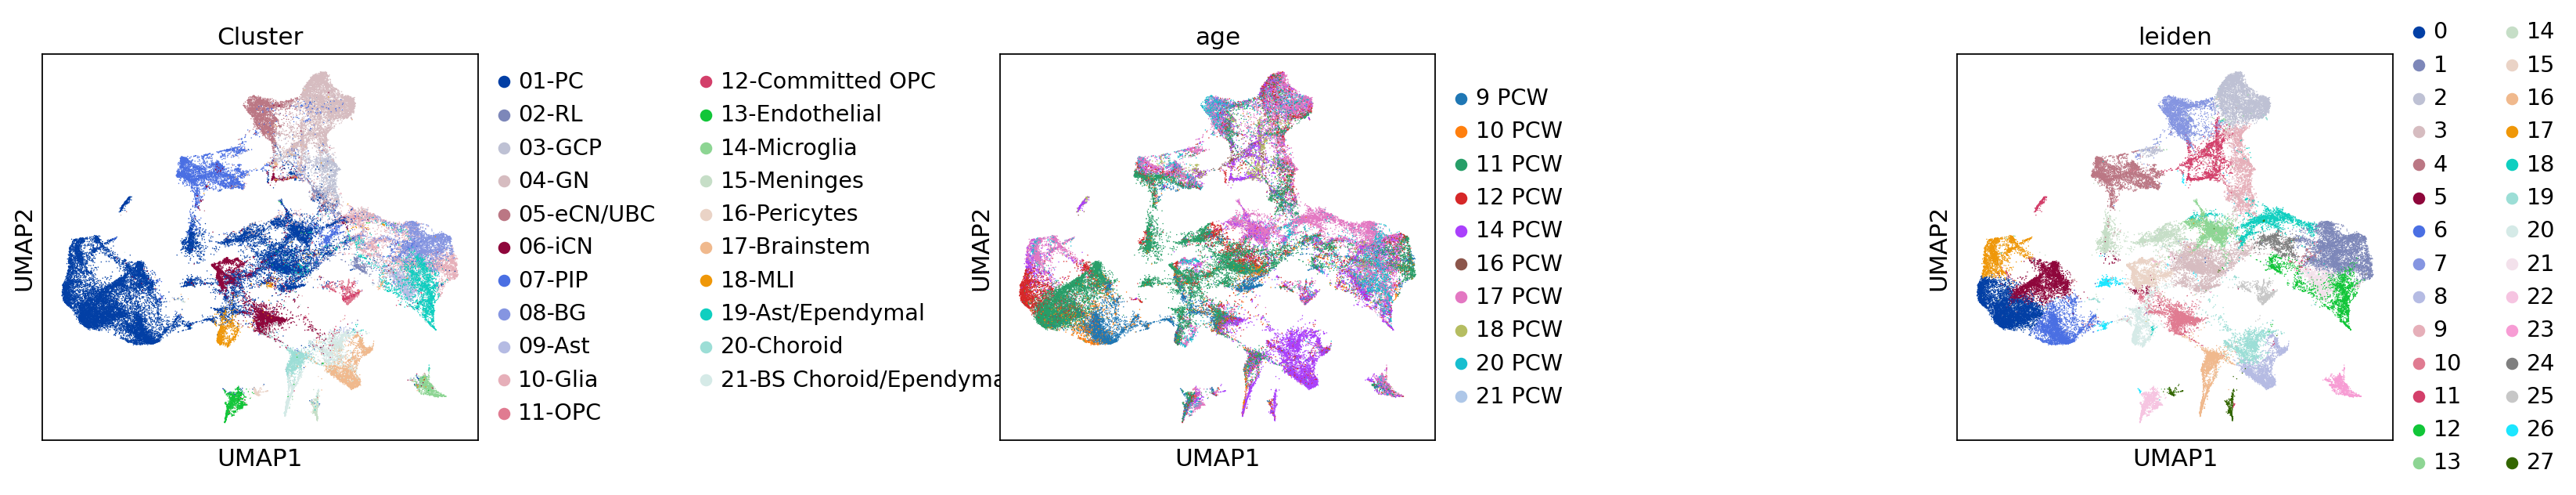

In [34]:
sc.pl.umap(adata, color=["Cluster", 'age', "leiden"], wspace = 1, save = "AldingerEtal_UMAP.pdf")

In [31]:
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['Cluster'].cat.categories)                                                                                                 

for clust in adata.obs.Cluster.cat.categories: 
    res.loc[clust] = adata[adata.obs['Cluster'].isin([clust]),:].X.mean(0)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
res

HK2     PINX1   MT-RNR2   DSCAML1   DENND2A  \
01-PC                    -0.05804 -0.011133  0.078654 -0.295308 -0.092757   
02-RL                    0.550817 -0.006391  0.312645 -0.009944  0.259294   
03-GCP                   0.258543 -0.022144 -0.085498 -0.291104    0.1333   
04-GN                   -0.099686 -0.022246 -0.102052   0.92746  0.008211   
05-eCN/UBC               0.149789 -0.037801 -0.059167  1.204179   0.29511   
06-iCN                  -0.124897  0.024007  0.013362 -0.079971 -0.048189   
07-PIP                   -0.04593 -0.026767 -0.018665  1.011312 -0.149804   
08-BG                    0.003311  -0.00611 -0.061248 -0.521662  0.073766   
09-Ast                   0.065464 -0.007788 -0.079214 -0.592185  0.198583   
10-Glia                  0.082016 -0.039429 -0.018024 -0.374093   0.09109   
11-OPC                   0.001919  0.003571 -0.174864   0.00477  0.062451   
12-Committed OPC         0.204979  0.095906 -0.149292   0.99224  0.025469   
13-Endothelial          -0.032214 -0.028584  0.101479 -0.075994   0.21777   
14-Microglia             1.684095 -0.029532 -0.234062 -0.142095 -0.068137   
15-Meninges             -0.039622  -0.01386  -0.29677 -0.301192  0.409244   
16-Pericytes              0.19178  0.093272 -0.101898 -0.179625  0.853298   
17-Brainstem            -0.123905 -0.046423 -0.304993 -0.308925  0.074154   
18-MLI                  -0.088373  -0.01753  0.112638  0.106835   -0.1724   
19-Ast/Ependymal        -0.006027 -0.042983 -0.066405 -0.372617  0.083602   
20-Choroid              -0.058707  -0.06832  0.244824  -0.22334 -0.136599   
21-BS Choroid/Ependymal -0.007513 -0.027428 -0.015782  0.058637  0.254663   

                              NXN       EYS    DNAJB6   TMEM205      CA10  \
01-PC                    0.005366 -0.115344  -0.07226 -0.022512 -0.252961   
02-RL                    0.236219  0.597869    0.0479  -0.00575 -0.290251   
03-GCP                   0.210221   0.27373  0.075578 -0.048063 -0.310218   
04-GN                   -0.113249  0.583006 -0.102481 -0.035317  0.472363   
05-eCN/UBC              -0.191434  0.589685 -0.027341 -0.048138 -0.292029   
06-iCN                  -0.180275 -0.157401 -0.040812  0.027008  0.538264   
07-PIP                   0.251846 -0.078142 -0.005479 -0.014727 -0.190053   
08-BG                    -0.04087 -0.174202  0.030345 -0.007794  -0.38904   
09-Ast                  -0.170311 -0.189031  0.030261  0.007838 -0.281039   
10-Glia                  0.155095 -0.107839   0.42583  -0.01678 -0.331728   
11-OPC                   -0.15322  0.002491 -0.053694 -0.041024   1.84963   
12-Committed OPC        -0.084952  0.806241 -0.124578  0.012122  1.138934   
13-Endothelial           0.457886  0.087814  0.353424 -0.044783 -0.048943   
14-Microglia             0.221378  -0.02216  0.351814  0.012649 -0.066388   
15-Meninges              0.787066 -0.154658  0.042627  -0.03721  0.143702   
16-Pericytes             0.369772   0.02158 -0.004754  0.037869 -0.029362   
17-Brainstem            -0.161117 -0.200721 -0.011223 -0.034673  0.920934   
18-MLI                  -0.122737 -0.130452 -0.007659 -0.012905  0.502558   
19-Ast/Ependymal        -0.068496 -0.159896  0.093358   -0.0163 -0.330458   
20-Choroid              -0.234887 -0.084706  -0.17403  -0.03852  0.519395   
21-BS Choroid/Ependymal -0.008309 -0.181446 -0.004156  0.071344  0.939652   

                         ... C10orf107 AC008155.1 C14orf105 CTD-2031P19.4  \
01-PC                    ... -0.059155   -0.01058 -0.066216     -0.014695   
02-RL                    ... -0.073762   0.015056 -0.044884     -0.011906   
03-GCP                   ... -0.090522  -0.042577 -0.083368     -0.025593   
04-GN                    ...   -0.0779  -0.043228 -0.081773      -0.02146   
05-eCN/UBC               ... -0.072726  -0.036096 -0.083646     -0.040857   
06-iCN                   ... -0.038044  -0.007436 -0.080274     -0.009834   
07-PIP                   ... -0.067352  -0.003834 -0.078967     -0.029969   
08-BG                   

In [35]:
res.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/AldingerEtal2020_Celltypes_pseudobulk.csv')

In [36]:
adata.write(results_file)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:53)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/przybilm/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/przybilm/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmen

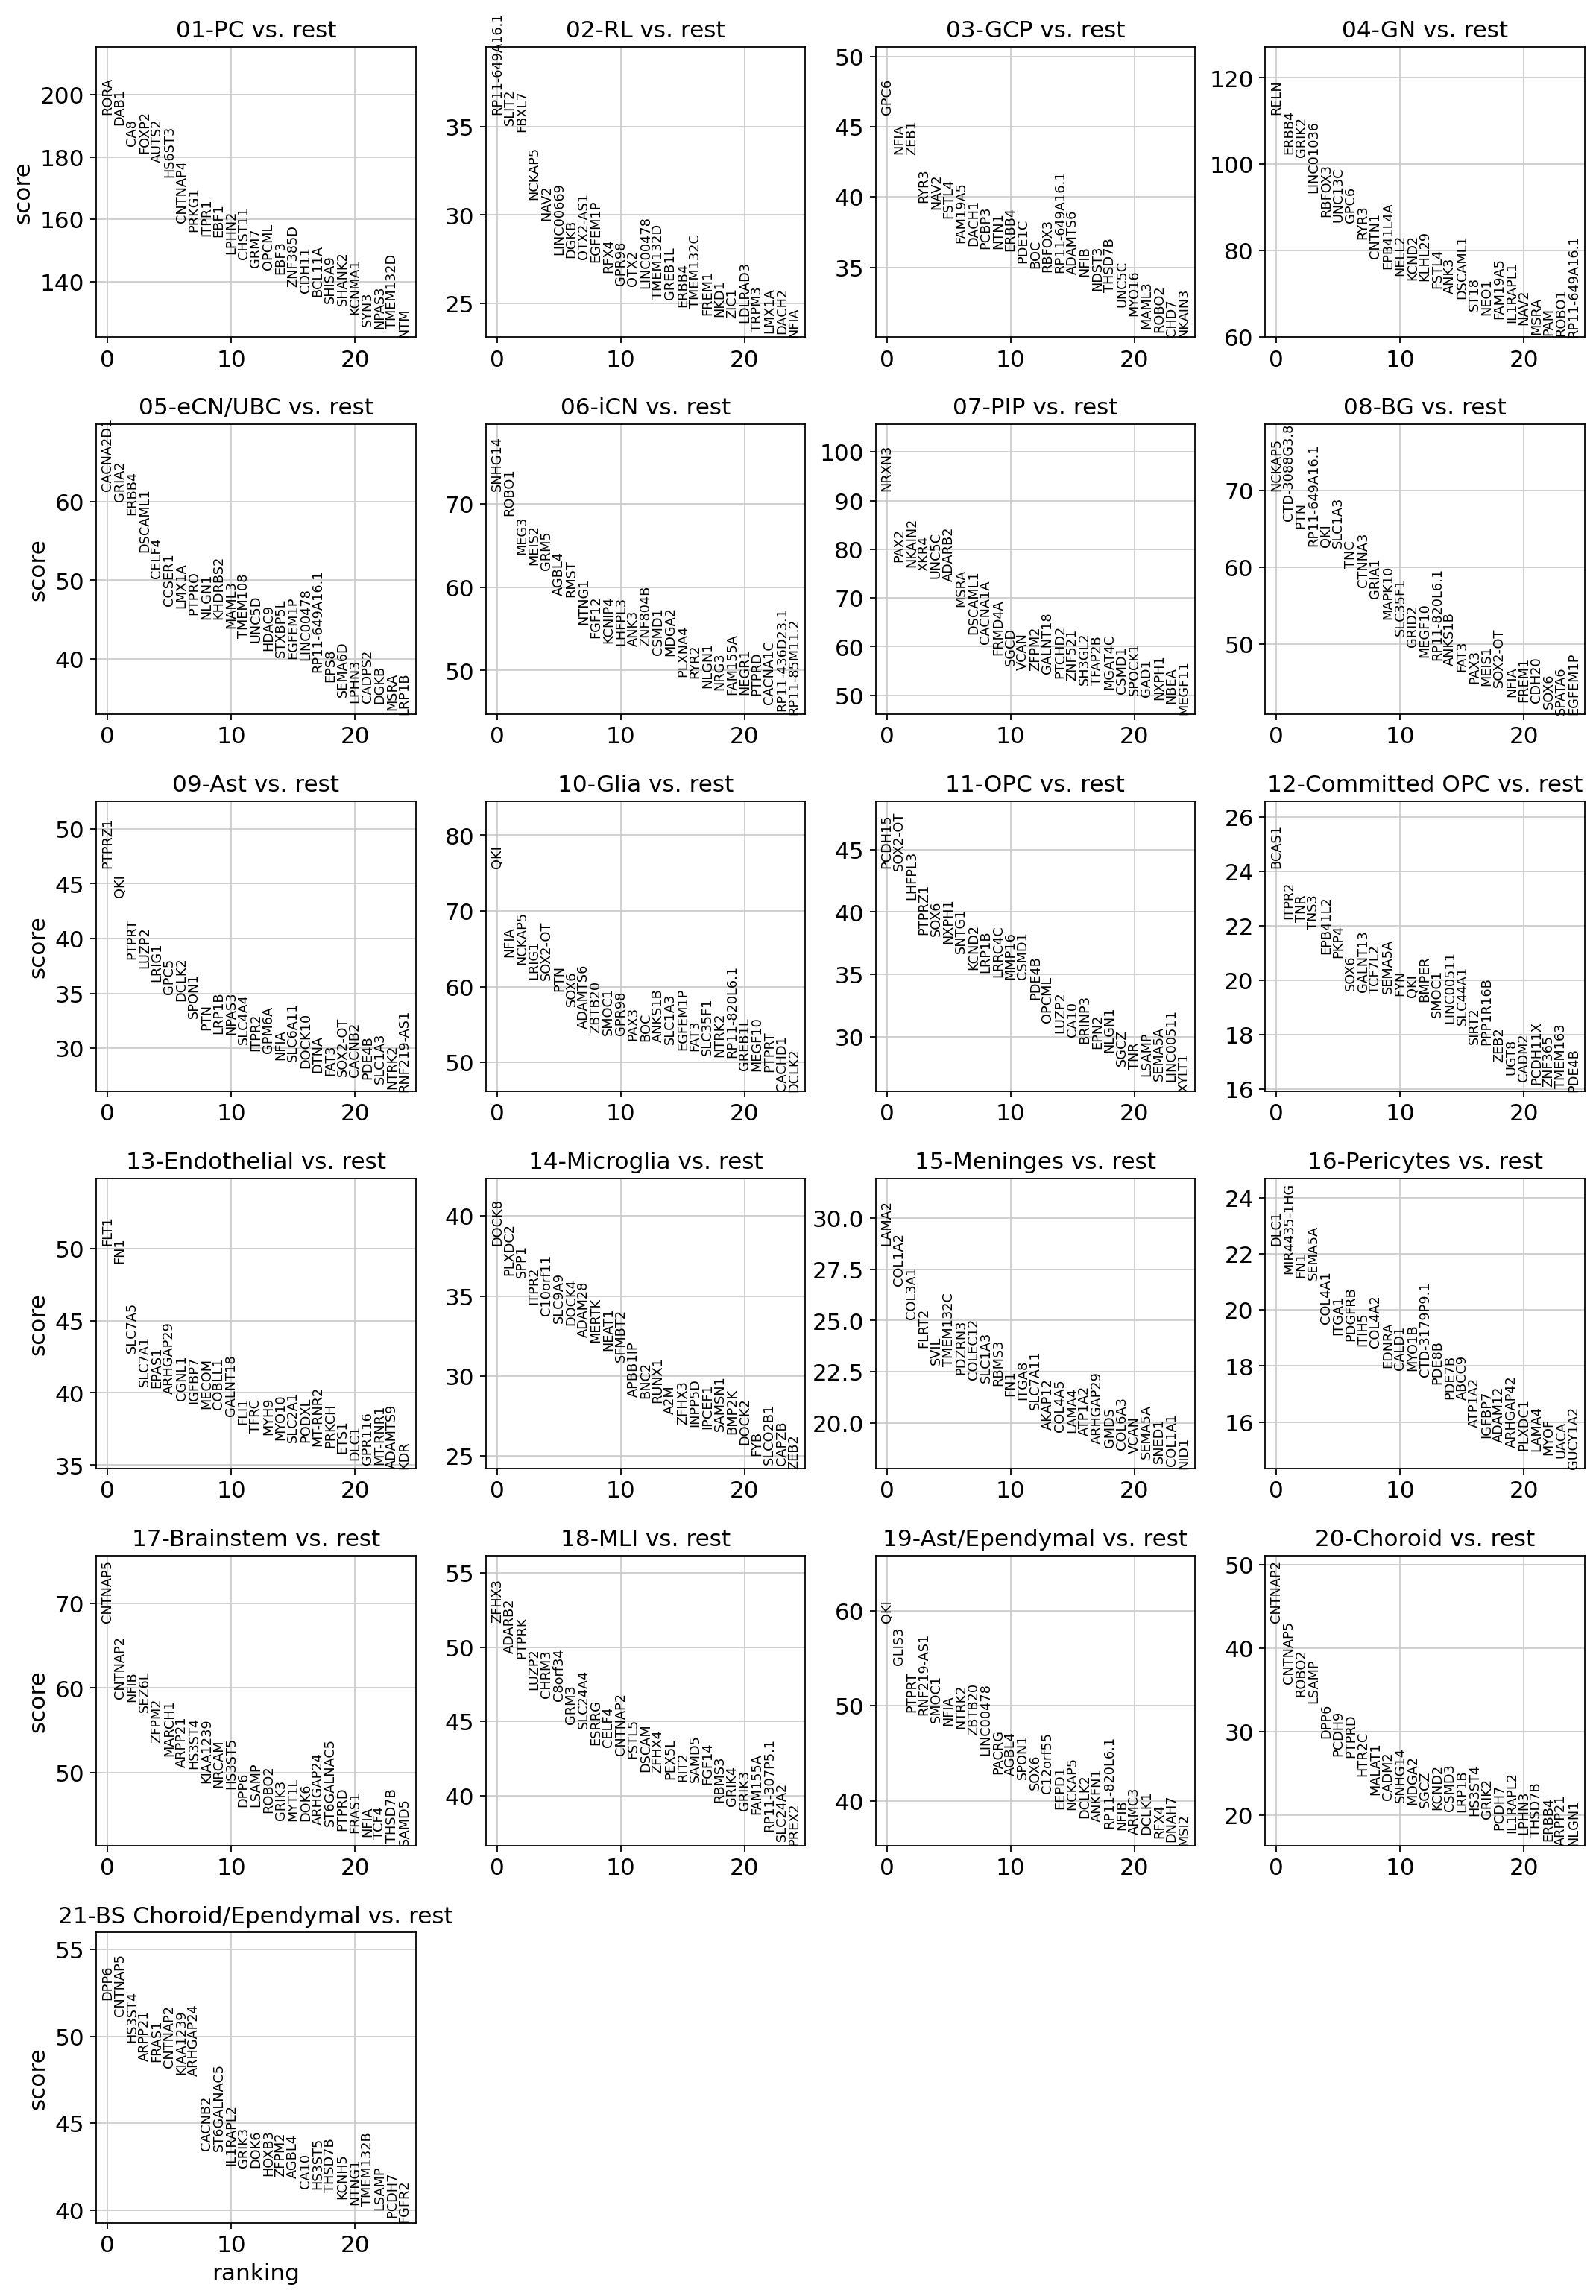

In [38]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'Cluster', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_AldingerEtal_CellTypes.pdf")

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [40]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)

01-PC          02-RL         03-GCP          04-GN     05-eCN/UBC  \
0       RORA  RP11-649A16.1           GPC6           RELN       CACNA2D1   
1       DAB1          SLIT2           NFIA          ERBB4          GRIA2   
2        CA8          FBXL7           ZEB1          GRIK2          ERBB4   
3      FOXP2         NCKAP5           RYR3      LINC01036        DSCAML1   
4      AUTS2           NAV2           NAV2         RBFOX3          CELF4   
5     HS6ST3      LINC00669          FSTL4         UNC13C         CCSER1   
6    CNTNAP4           DGKB        FAM19A5           GPC6          LMX1A   
7      PRKG1       OTX2-AS1          DACH1           RYR3          PTPRO   
8      ITPR1        EGFEM1P          PCBP3          CNTN1          NLGN1   
9       EBF1           RFX4           NTN1       EPB41L4A        KHDRBS2   
10     LPHN2          GPR98          ERBB4          NELL2          MAML3   
11    CHST11           OTX2          PDE1C          KCND2        TMEM108   
12      GRM7      LINC00478            BOC         KLHL29          UNC5D   
13     OPCML       TMEM132D         RBFOX3          FSTL4          HDAC9   
14      EBF3         GREB1L  RP11-649A16.1           ANK3        STXBP5L   
15   ZNF385D          ERBB4        ADAMTS6        DSCAML1        EGFEM1P   
16     CDH11       TMEM132C           NFIB           ST18      LINC00478   
17    BCL11A          FREM1          NDST3           NEO1  RP11-649A16.1   
18    SHISA9           NKD1         THSD7B        FAM19A5           EPS8   
19    SHANK2           ZIC1          UNC5C       IL1RAPL1         SEMA6D   
20    KCNMA1        LDLRAD3          MYO16           NAV2          LPHN3   
21      SYN3          TRPM3          MAML3           MSRA         CADPS2   
22     NPAS3          LMX1A          ROBO2            PAM           DGKB   
23  TMEM132D          DACH2           CHD7          ROBO1           MSRA   
24       NTM           NFIA         NKAIN3  RP11-649A16.1          LRP1B   

           06-iCN   07-PIP          08-BG      09-Ast       10-Glia  ...  \
0          SNHG14    NRXN3         NCKAP5      PTPRZ1           QKI  ...   
1           ROBO1     PAX2   CTD-3088G3.8         QKI          NFIA  ...   
2            MEG3   NKAIN2            PTN       PTPRT        NCKAP5  ...   
3           MEIS2     XKR4  RP11-649A16.1       LUZP2         LRIG1  ...   
4            GRM5    UNC5C            QKI       LRIG1       SOX2-OT  ...   
5           AGBL4   ADARB2         SLC1A3        GPC5           PTN  ...   
6            RMST     MSRA            TNC       DCLK2          SOX6  ...   
7           NTNG1  DSCAML1         CTNNA3       SPON1       ADAMTS6  ...   
8           FGF12  CACNA1A          GRIA1         PTN        ZBTB20  ...   
9          KCNIP4   FRMD4A         MAPK10       LRP1B         SMOC1  ...   
10         LHFPL3     SGCD        SLC35F1       NPAS3         GPR98  ...   
11           ANK3     VCAN          GRID2      SLC4A4          PAX3  ...   
12        ZNF804B    ZFPM2         MEGF10       ITPR2           BOC  ...   
13          CSMD1  GALNT18   RP11-820L6.1       GPM6A        ANKS1B  ...   
14          MDGA2   PTCHD2         ANKS1B        NFIA        SLC1A3  ...   
15         PLXNA4   ZNF521           FAT3     SLC6A11       EGFEM1P  ...   
16           RYR2   SH3GL2           PAX3      DOCK10          FAT3  ...   
17          NLGN1   TFAP2B          MEIS1        DTNA       SLC35F1  ...   
18           NRG3   MGAT4C        SOX2-OT        FAT3         NTRK2  ...   
19        FAM155A    CSMD1           NFIA     SOX2-OT  RP11-820L6.1  ...   
20          NEGR1   SPOCK1          FREM1      CACNB2        GREB1L  ...   
21          PTPRD     GAD1          CDH20       PDE4B        MEGF10  ...   
22        CACNA1C    NXPH1           SOX6      SLC1A3         PTPRT  ...   
23  RP11-436D23.1     NBEA         SPATA6       NTRK2        CACHD1  ...   
24   RP11-85M11.2   MEGF11        EGFEM1P  RNF219-AS1         DCLK2  ...   

   12-Committed OPC 13-Endothelial 14-Microglia 15-Me

In [41]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/AldingerEtal2020_DEG_wilcoxon.csv")